In [140]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import operator
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [141]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'PAD', 1: 'SOS', 2:'EOS', 3:'UNK'}#Dict
        self.n_words = 4  # Count SOS and EOS +(batch: pad and unk)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [142]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4491
eng 2927
['je conduis .', 'i m driving .']


In [143]:
pairs[419]

['nous sommes seules .', 'we re alone .']

### The above is the data preparation stage(for single batch). No code shall be changed. 

### Batch size modification
----
1. pairs -> refers to Fr-En letter pairs
2. index_pairs -> refers to Fr-En index pairs

In [144]:
class NMTDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang):#Needs the index pairs
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.input_seqs = [pairs[i][0] for i in range(len(self.pairs))]
        self.output_seqs = [pairs[i][1] for i in range(len(self.pairs))]

    def __len__(self):
        return len(self.pairs)#Returning number of pairs
    
    def __getitem__(self, index):
        input_seq = self.input_seqs[index]
        output_seq = self.output_seqs[index]
        return [input_seq, len(input_seq), output_seq, len(output_seq)]
    
def vocab_collate_func(batch):
    #Reference: lab8_3_mri
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
        padded_seqs = torch.zeros(len(seqs), max(lens)).long()
        for i, seq in enumerate(seqs):
            end = lens[i]
            padded_seqs[i, :end] = torch.LongTensor(seq[:end])
        return padded_seqs, lens
    
    batch_input_seqs = [datum[0] for datum in batch]
    batch_output_seqs = [datum[2] for datum in batch]
    #batch_input_length = [datum[1] for datum in batch]
    #batch_output_length = [datum[3] for datum in batch]

    sorted_pairs = sorted(zip(batch_input_seqs, batch_output_seqs), key=lambda x: len(x[0]), reverse = True)
    in_seq_sorted, out_seq_sorted = zip(*sorted_pairs)
    
    padded_input,input_lens = _pad_sequences(in_seq_sorted)
    padded_output,output_lens = _pad_sequences(out_seq_sorted)
    
    return [torch.from_numpy(np.array(padded_input)),
            torch.LongTensor(input_lens),
            torch.from_numpy(np.array(padded_output)),
            torch.LongTensor(output_lens)]

In [145]:
index_pairs = [[indexesFromSentence(input_lang, pairs[i][0]),
                indexesFromSentence(output_lang, pairs[i][1])] for i in range(len(pairs))]
#index_pairs = indexesFromPair(pair)

'''
NMTDataset needs index pairs, need to call indexesFromPairs functions beforehand
The dataLoader is sorted according to length of the input_length, and padded to
max length of input and output list repectively
TODO: output_list is not sorted, hence need to sort (maybe) in the rnn sequence.
'''
train_dataset = NMTDataset(index_pairs, input_lang, output_lang)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                          batch_size = BATCH_SIZE,
                                          collate_fn = vocab_collate_func,
                                          shuffle = True)
#Input_batch in size Batch x maxLen


In [146]:
# #Test for batch sizes
# for i, (input_list, input_length, output_list, output_length) in enumerate(train_loader):
#     if i== 0:
#         break

In [147]:
input_list.size()

torch.Size([3, 9])

In [16]:
input_length

tensor([8, 5, 5])

In [17]:
output_list.size()

torch.Size([3, 8])

In [18]:
output_length

tensor([8, 6, 6])

## 1. First test out with no batch size

### 1.1 Encoder with no batch

In [148]:
#Here for the constant definition
MAX_SENTENCE_LENGTH = 10
hidden_size = 256
max_length = 10
BATCH_SIZE = 3
TEST_BATCH_SIZE = 3


In [ ]:
#unbatched RNNEncoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1) # B x 1 x H
        #print('The embeddded size is {}'.format(embedded.size()))
        #When feeded in batch sizes, the size will be B x 1 x H, one token at a time
        output = embedded##Need changes if doing the batch size
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size, device = device)

In [ ]:
#For 1 batch size, prepare the test data
source_list = [pairs[i][0] for i in range(10)]
output_list = [pairs[i][1] for i in range(10)]

#Here they are strings:
input_tensor = source_list[0]
output_tensor = output_list[0]

#Transfer to tensor
input_tensor = tensorFromSentence(input_lang, input_tensor)
output_tensor = tensorFromSentence(output_lang, output_tensor)


In [ ]:
encoder = EncoderRNN(input_lang.n_words, hidden_size)
if device == torch.device('cuda'):
    encoder.cuda()
else:
    encoder.cpu()

In [ ]:
input_length = input_tensor.size(0)
output_length = output_tensor.size(0)

encoder_outputs = torch.zeros(MAX_SENTENCE_LENGTH, 
                              encoder.hidden_size, 
                              device = device)#10x256
encoder_hidden = encoder.initHidden()#1x1x256

#Encode the sentence one index at a time
for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0,0]

### 1.2 Encoder with batch

In [149]:
class BatchEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, n_layers=1, dropout=0.1):
        super(BatchEncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional = True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        '''
        input_seqs in size B x L sorted in decreasing order -> will transpose to fit in embedding dimension
        '''
        embedded = self.embedding(input_seqs.transpose(0,1))#input_seqs B x L -> transpose to L x B
        #Input length sorted by loader
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        #Outputs in shape L x B x 2H, hidden as the last state of the GRU
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        hidden = hidden[:self.n_layers, :, :] + hidden[self.n_layers:,:,:]#Sum bidrectional information
        #outputs L x B x H
        #hidden size (n_layers) x B x H

        #outputs: seq_len x Batch x H
        return outputs, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers *2, self.batch_size, self.hidden_size,device = device)#hidden size 2lays *B*H

### Dimension test

In [150]:
batch_encoder = BatchEncoderRNN(input_lang.n_words, hidden_size, BATCH_SIZE, n_layers = 2, dropout = 0.1)
init_hidden = batch_encoder.initHidden()
encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, init_hidden)
#inithidden bidirectional, encoder_hidden, summing up both directions
init_hidden.size(), encoder_outputs.size(), encoder_hidden.size()

(torch.Size([4, 3, 256]), torch.Size([9, 3, 256]), torch.Size([2, 3, 256]))

### 1.3 Decoder with Attention
The decoder has already been batchified. Therefore 
if feeding 1 sentence at a time make sure unsqueeze the batch dimension

In [151]:
#Reference: lab8 3_mri, Luong model
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            #self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def forward(self, hidden, encoder_outputs):
        # Create variable to store attention energies
        # For each batch of encoder outputs Calculate energy for each encoder output
        beta = self.score(hidden, encoder_outputs)#Len x Batch
        #print('The size for beta is {}'.format(beta.size()))
        alpha = F.softmax(beta.transpose(0,1)).unsqueeze(1)#B x 1 x L
        #encoder_ouputs L x B x H originally -> transpose to B x L x H
        #alpha bmm encoder_outputs: B x 1 x L bmm B x L x H -> B x 1 x N
        context = alpha.bmm(encoder_outputs.transpose(0,1))#B X 1 X N        
        
        # Return context vectors and attnetion weights for visualization
        return context, alpha
    
    def score(self, hidden, encoder_outputs):
        
        if self.method == 'dot':
            ## TODO implement
            energy = torch.sum(hidden*encoder_outputs, 2)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_outputs)
            ## TODO implement 
            energy = torch.sum(hidden*energy,2)
            return energy
        
        elif self.method == 'concat':
            cat = torch.cat((hidden.repeat(encoder_outputs.size(0), 1,1),encoder_outputs),dim=2)
            energy = F.tanh(self.attn(cat))
            ## TODO implement 
            energy = torch.sum(self.v * energy, 2)
            return energy

In [152]:
#Reference Lab8 3-mri, Luong model
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD_TOKEN)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x H

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        context, alpha = self.attn(rnn_output, encoder_outputs)

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)
        #Softmax to get the distribution
        output = F.softmax(output, dim=1)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, alpha

In [154]:
decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)
decoder_input = torch.tensor([[SOS_TOKEN]], device=device).repeat(TEST_BATCH_SIZE,1)
#decoder_hidden = encoder_hidden[:decoder_test.n_layers]
decoder_hidden = encoder_hidden
input_seq = decoder_input
last_hidden = decoder_hidden
attn_model = 'dot'
decoder_input.size(), decoder_hidden.size()
decoder_output, decoder_hidden, attn_weights = decoder_test(decoder_input, decoder_hidden, encoder_outputs)

#Test rounds
all_decoder_outputs = torch.zeros(output_length.max().item(), TEST_BATCH_SIZE, decoder_test.output_size)
for t in range(output_length.max().item()):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(decoder_input, decoder_hidden, encoder_outputs)
    all_decoder_outputs[t] = decoder_output
    decoder_input = output_list[:,t].unsqueeze(1)

# For single interations only, encoer_outputs already unsqueezed 

In [ ]:
#encoder_outputs = encoder_outputs.unsqueeze(0)
encoder_outputs.size()

In [ ]:
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words)
if device == torch.device('cuda'):
    attn_decoder.cuda()
else:
    attn_decoder.cpu()

In [ ]:
decoder_input = torch.tensor([[SOS_TOKEN]], device = device)
decoder_hidden = encoder_hidden#1x1x256

In [ ]:
for di in range(output_length):
    decoder_output, decoder_hidden, decoder_attntion = attn_decoder(decoder_input, 
                                                     decoder_hidden, encoder_outputs)
    decoder_input = output_tensor[di]

## Note: Encoder outputs remained unchanged -> can be used later for testing
# End of the decoder and encoder session
code shall not be changed. 
two sentence has already been encoded and now we
aim to generate best translation

## During the train, will not  have inference state
### During training, no beam needed -> only during the evaluations state -> reference: Chow's note
two methods: greedy and beam search

# First greedy search: training and evaluations

In [138]:
#Greedy search
#DOnt execute these
#Training process:
teacher_forcing_ratio = 0.6
use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

if use_teacher_forcing:
    # Teacher forcing: Feed the target as the next input
    for di in range(output_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

else:
    # Without teacher forcing: use its own predictions as the next input
    for di in range(output_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        #topv is the score, topi is the index of the highest score
        topv, topi = decoder_output.topk(1)

        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_TOKEN:
            break

TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
#initialize the decoder_hidden here
decoder_input = torch.tensor([[SOS_TOKEN]], device = device)
decoder_hidden = encoder_hidden#1x1x256

In [139]:
#Evaluations:
decoded_words = []
decoder_attentions = torch.zeros(max_length, max_length)

for di in range(max_length):
    decoder_output, decoder_hidden, decoder_attention = attn_decoder(decoder_input, decoder_hidden, encoder_outputs)
    topv, topi = decoder_output.topk(1)#Take the best one
    #teacher forcing or not
    #decoder_input = topi.squeeze().detach()
    decoder_input = output_tensor[di]#For next round
    decoder_attentions[di] = decoder_attention[0,0]
    decoded_words.append(output_lang.index2word[topi.item()])#append the best token right now
    
    if decoder_input.item() == EOS_TOKEN:

        break;

NameError: name 'attn_decoder' is not defined

In [ ]:
decoder_attentions

# Second Beam Search: 

In [ ]:
class SearchNode(object):
    def __init__(self, word_idx, hidden, curr_score, prev, curr_length):
        self.word_idx = word_idx#Tensor        
        self.hidden = hidden
        self.prev = prev
        if self.prev == None:
            self.score = curr_score
        else:
            self.score = self.prev.score + curr_score#The score summed up so far
        
        self.curr_length = curr_length #the nth node in the sentence
        #self.next = None
    


In [ ]:
def init_beam(decoder_hidden, encoder_outputs, decoder, beam_width):
    decoder_input = torch.tensor([[SOS_TOKEN]], device = device)
    start_node = SearchNode(decoder_input,decoder_hidden, 0,None,1 )
    
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
    curr_nodes = []
    scores, indexes = torch.topk(decoder_output, beam_width)##Watch out for dimension, topk on the vocab direction
    for i in range(beam_width):
        curr_idx = indexes[0][i].view(1,-1)
            
        curr_score = scores[0][i].item()
        curr_node = SearchNode(curr_idx, decoder_hidden, curr_score, start_node, 2)
        curr_nodes.append((curr_node, curr_score))
        
    return curr_nodes, decoder_hidden

def beam_search(decoder_hidden,encoder_outputs,decoder,beam_width, k):
    '''
    beam_width: number of best nodes kept at each iterations
    k: number of sentences we want to keep
    '''
    curr_nodes, decoder_hidden = init_beam(decoder_hidden, encoder_outputs, decoder, beam_width)

    end_nodes = []#List including the ending nodes to trace back i.e. the EOS's
    #n_needed = min((k+1), k-len(end_nodes))
    
    while len(end_nodes) < k:
        candidate_nodes = []   
        for curr_node, curr_score in curr_nodes:
            
            #First we decide whether to terminate the search or not            
            if (curr_node.word_idx == EOS_TOKEN):#If already at the end of the sentence, then skip the calculation
                end_nodes.append((curr_node, curr_node.score))
                if len(end_nodes) >= k: #if already has the desired number of sentences generated
                    break;
                else:
                    continue;
                          
            #If the inference takes too long, also termiantes
            if curr_node.curr_length == 2000: #if too long will force to stop
                #Create an EOS dummy node to trace back the entire sentence
                
                EOS_node = SearchNode(torch.tensor([[EOS_TOKEN]], device = device), curr_node.hidden, 
                                      curr_node.score, curr_node, (curr_node.curr_length)+1)
                end_nodes.append((EOS_node, EOS_node.score))
                if len(end_nodes) >= k:
                    break;
                else:
                    continue;
            
            #If not, continue to inference the current time step choices, given the current node
            decoder_input = curr_node.word_idx
            decoder_hidden = curr_node.hidden
            decoder_output, decoder_hidden,decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #Pick out k best for the current node
            scores, indexes = torch.topk(decoder_output, beam_width)##Watch out for dimension, topk on the vocab direction
            for i in range(beam_width):
                candidate_idx = indexes[0][i].view(1,-1)
                candidate_score = scores[0][i].item()
                candidate_node = SearchNode(candidate_idx, decoder_hidden, candidate_score, curr_node, (curr_node.curr_length)+1)

                candidate_nodes.append((candidate_node, candidate_node.score))
        
        #Will now have candidate candidate_nodes with size beam_width * beam_width, only need the top beam_width one.
        curr_nodes = sorted(candidate_nodes, key = operator.itemgetter(1))
        curr_nodes = curr_nodes[:beam_width]

    return end_nodes              

In [ ]:
#Translate the sentences.
def translate_end_nodes(end_nodes):
    sentences = []
    end_nodes = sorted(end_nodes, key = operator.itemgetter(1),reverse = True)
    for end_node, _ in end_nodes:
        sentence = []
        while end_node.prev != None:
            sentence.append(output_lang.index2word[end_node.word_idx.item()])
            end_node = end_node.prev
        sentence = sentence[::-1]#Reverse the sentence to get the sentence
        sentences.append(sentence)
    return sentences

# beam search test

In [ ]:
#initialize the decoder_hidden here
decoder_input = torch.tensor([[SOS_TOKEN]], device = device)
decoder_hidden = encoder_hidden#1x1x256

In [ ]:
#Test if the batch is unsqueezed; only doing so when batch not implemented and hidden size = 256 max_length = 10
list(encoder_outputs.size()) == [1, 10, 256]

In [ ]:
end_nodes = beam_search(decoder_hidden, encoder_outputs, decoder = attn_decoder, beam_width = 10, k = 1)

In [ ]:
end_nodes

In [ ]:
result = translate_end_nodes(end_nodes)
print(len(result[0]))
result[0][:20]

# End of testing beam search

In [ ]:
#Evaluations: beam_width = 2
end_nodes = beam_search(decoder_hidden, encoder_outputs,decoder = attn_decoder, k=2)


Train the lab data, if workable, then implement the mini-batch

## Single batch testing

In [ ]:
teacher_forcing_ratio = 0.5
MAX_LENGTH = 10
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_TOKEN:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [191]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, n_layers=1, dropout_p=0.1).to(device)
#Training test: 
trainIters(encoder1, attn_decoder1, 75000, print_every=5000) 
#It worked.

# Batch Train
---
### Disintegration of train function

In [98]:
batch_encoder_test = BatchEncoderRNN(input_lang.n_words, hidden_size, TEST_BATCH_SIZE, n_layers = 2, dropout = 0.1)
init_hidden = batch_encoder.initHidden()
encoder_outputs, encoder_hidden = batch_encoder_test(input_list, input_length, init_hidden)

In [99]:
attn_model = 'dot'
batch_decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)




In [101]:
learning_rate = 0.1
encoder_optimizer = optim.SGD(batch_encoder_test.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(batch_decoder_test.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()


In [109]:
MAX_OUTPUT_LENGTH = output_length.max().item()
decoder_outputs = torch.zeros(MAX_OUTPUT_LENGTH, TEST_BATCH_SIZE, hidden_size)

### End of disintegration
---
#### Define batch train function

In [201]:
output_list

tensor([[ 16,  42, 780,  30, 755, 917,   6],
        [  4,   5, 397, 674, 607,   6,   0],
        [132,  80, 342,   6,   0,   0,   0]])

In [202]:
test_list = output_list.transpose(0,1)

In [203]:
test_list

tensor([[ 16,   4, 132],
        [ 42,   5,  80],
        [780, 397, 342],
        [ 30, 674,   6],
        [755, 607,   0],
        [917,   6,   0],
        [  6,   0,   0]])

In [205]:
test_list[0].size()

torch.Size([3])

In [206]:
slice_test = test_list[0]

In [207]:
slice_test

tensor([ 16,   4, 132])

In [208]:
slice_test[0]

tensor(16)

In [209]:
topv, topi = decoder_output.topk(1)

In [212]:
topi.size()

torch.Size([3, 1])

In [216]:
(topi == 1394).sum().item()

1

In [239]:
teacher_forcing_ratio = 0.5
MAX_LENGTH = 10
def batch_train(input_list, input_length, output_list,output_length, batch_encoder, batch_decoder, encoder_optimizer, decoder_optimizer, criterion):
    batch_encoder.train()
    batch_decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    max_output_length = output_length.max().item()


#     input_length = input_tensor.size(0)
#     target_length = target_tensor.size(0)

#     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0

    #batch_encoder = BatchEncoderRNN(input_lang.n_words, hidden_size, BATCH_SIZE, n_layers = 2, dropout = 0.1)
    init_hidden = batch_encoder.initHidden()
    encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, init_hidden)

    #Initialize for decoding process
    curr_batch = input_list.size(0)#Take the current batch size
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device).repeat(curr_batch,1)
    decoder_hidden = encoder_hidden#Bidirectional summoned
    #encoder_outputs : L x B x H
    decoder_outputs = torch.zeros(max_output_length, curr_batch, batch_decoder.output_size)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = batch_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[di] = decoder_output
            loss += criterion(decoder_output, output_list[:,di])
            decoder_input = output_list[:,di].unsqueeze(1)  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = batch_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()# detach from history as input: size batch x 1 

            loss += criterion(decoder_output, output_list[:, di])
            if ((decoder_output == EOS_TOKEN).sum().item()) == decoder_output.size(0):#If all are EOS tokens
                break;
            


    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / max_output_length

Train function testing

In [240]:
batch_encoder_test = BatchEncoderRNN(input_lang.n_words, hidden_size, TEST_BATCH_SIZE, n_layers = 2, dropout = 0.1)
init_hidden = batch_encoder.initHidden()
# encoder_outputs, encoder_hidden = batch_encoder_test(input_list, input_length, init_hidden)
attn_model = 'dot'
batch_decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)

learning_rate = 0.1
encoder_optimizer = optim.SGD(batch_encoder_test.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(batch_decoder_test.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()



In [241]:
batch_train(input_list, input_length, output_list, output_length, 
            batch_encoder_test, batch_decoder_test, encoder_optimizer, 
           decoder_optimizer, criterion)

7.9817352294921875

In [244]:
#Breif test on tiny batch to see whether it is working.
batch_encoder_test = BatchEncoderRNN(input_lang.n_words, hidden_size, TEST_BATCH_SIZE, n_layers = 2, dropout = 0.1).to(device)
init_hidden = batch_encoder.initHidden()
# encoder_outputs, encoder_hidden = batch_encoder_test(input_list, input_length, init_hidden)
attn_model = 'general'
batch_decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)

learning_rate = 0.01
encoder_optimizer = optim.SGD(batch_encoder_test.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(batch_decoder_test.parameters(), lr=learning_rate)
#criterion = torch.nn.CrossEntropyLoss().cuda()
criterion = torch.nn.NLLLoss()

train_loss_list = []
for i in range(1000):
    loss = batch_train(input_list, input_length, output_list, output_length, 
            batch_encoder_test, batch_decoder_test, encoder_optimizer, 
           decoder_optimizer, criterion)
    train_loss_list.append(loss)


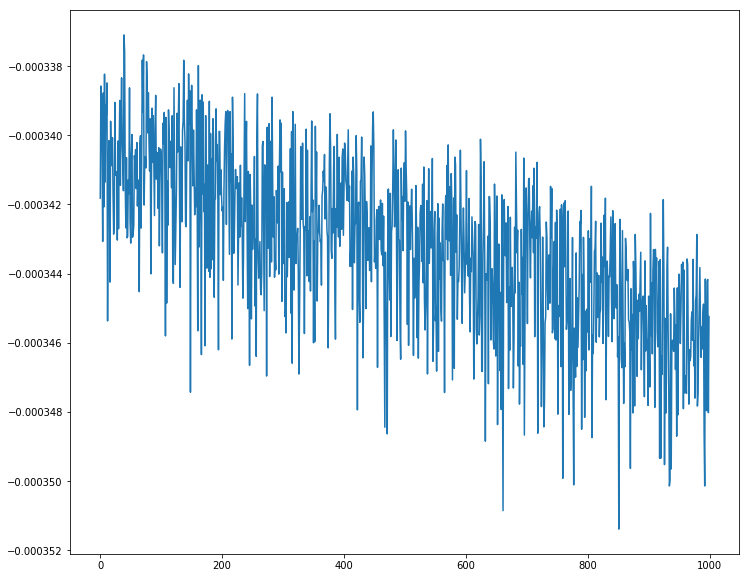

In [245]:
fig, ax = plt.subplots(figsize = (12,10))
ax.plot(train_loss_list)


In [ ]:
#JY added
def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()#use arange instead of range
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
#     if sequence_length.is_cuda:
#         seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):

    length = torch.tensor(length)


    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss